# Demonstration of default vs normalized covariance estimation

In [1]:
%matplotlib inline
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy import signal
from scipy.ndimage import gaussian_filter1d as smooth

from disp import set_plot

In [2]:
def xcor_direct(x, y, lag_bak, lag_fwd):
    """
    Calculate cross-correlation between x and y for multiple time-series.
    Positive lags correspond to correlations between x at an earlier time
    and y at a later time.
    :param x: input time-series
    :param y: output time-series
    :param lag_fwd: number of lags to look forward (causal (x yields y))
    :param lag_bak: number of lags to look back (acausal (y yields x))
    :return: correlation vs time lag
    """
    # estimate mean
    tcov = np.arange(lag_bak, lag_fwd)
    cov = np.nan*tcov

    # loop over timelags
    for clag, lag in enumerate(range(lag_bak, lag_fwd)):
        
        # align signals offset by lag
        if lag == 0:
            x_ = x
            y_ = y

        elif lag < 0:
            x_ = x[-lag:]
            y_ = y[:lag]

        elif lag > 0:
            x_ = x[:-lag]
            y_ = y[lag:]

        cov[clag] = np.sum((x_)*(y_)) / (len(x_) - 1)

    return cov, tcov

In [3]:
def xcor_conv_standard(x, y):
    """
    Estimate cross-correlation of two signals using scipy.signal.correlate.
    """
    if np.any(np.isnan(x)) or np.any(np.isnan(y)):
        # fft no work if nans
        xcov_temp = signal.correlate(x, y, mode='full', method='direct')
    else:
        xcov_temp = signal.correlate(x, y, mode='full')
        
    tcov = np.arange(-len(x)+1, len(x))
    
    return xcov_temp/len(x), tcov

In [4]:
def xcor_conv_tri(x, y):
    """
    Estimate cross-correlation of two signals using scipy.signal.correlate and then
    subsequently dividing by triangle function to account for time-lag-dependent
    differences in # samples going into cov estimate. This is useful if you expect
    slow timescales in the autocovariance function, since it is a more unbiased
    estimate of those timescales, but it can also lead to 'invalid' correlation functions
    """
    if np.any(np.isnan(x)) or np.any(np.isnan(y)):
        # fft no work if nans
        xcov_temp = signal.correlate(x, y, mode='full', method='direct')
    else:
        xcov_temp = signal.correlate(x, y, mode='full')
        
    tcov = np.arange(-len(x)+1, len(x))
    tri = (len(x)) - np.abs(tcov) - 1
    
    return xcov_temp/tri, tcov

# Estimate correlation function from long sample

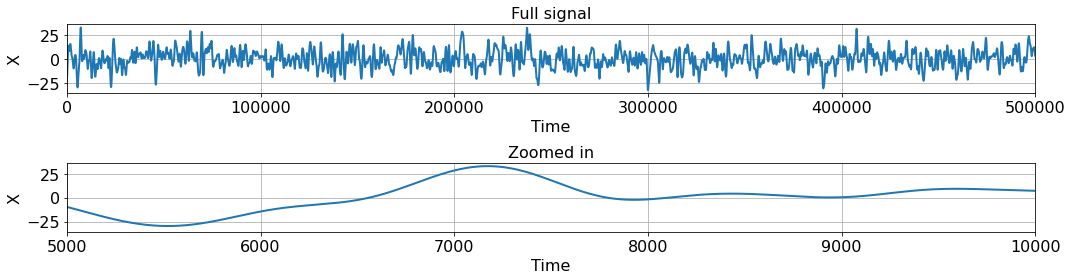

In [5]:
T = 500000
SMOOTH = 300

x = smooth(np.random.randn(T+1), SMOOTH)*SMOOTH

fig, axs = plt.subplots(2, 1, figsize=(15, 4), tight_layout=True)
for ax in axs:
    ax.plot(x, lw=2)
    title, x_lim = ('Full signal', (0, T)) if ax is axs[0] else ('Zoomed in', (5000, 10000))
    
    set_plot(ax, x_lim=x_lim, x_label='Time', y_label='X', title=title, font_size=16)
    ax.grid()

In [6]:
LAG_BAK = -500
LAG_FWD = 500

tcor = np.arange(-T, T+1)

mu_hat_x = np.mean(x)

cor_0, tcor_0 = xcor_direct(x-mu_hat_x, x-mu_hat_x, LAG_BAK, LAG_FWD)
cor_std = xcor_conv_standard(x-mu_hat_x, x-mu_hat_x)[0]
cor_tri = xcor_conv_tri(x-mu_hat_x, x-mu_hat_x)[0]

(-500.0, 500.0)

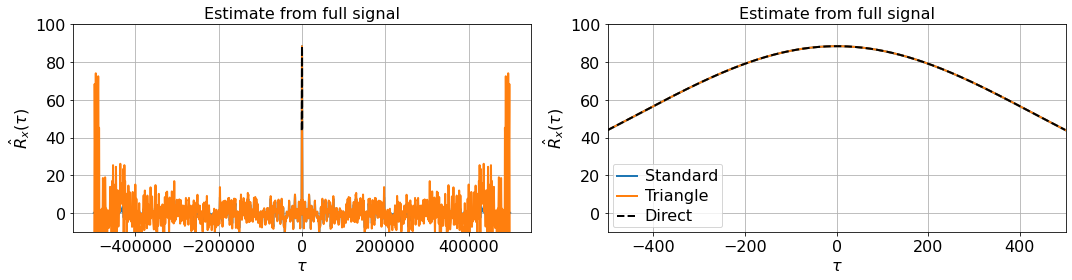

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4), tight_layout=True)
for ax in axs:
    ax.plot(tcor, cor_std, lw=2)
    ax.plot(tcor, cor_tri, lw=2)
    ax.plot(tcor_0, cor_0, c='k', ls='--', lw=2)

    if ax is axs[1]:
        ax.legend(['Standard', 'Triangle', 'Direct'])
    set_plot(ax, y_lim=(-10, 100), x_label=r'$\tau$', y_label=r'$\hat{R}_x(\tau)$', title='Estimate from full signal', font_size=16)
    ax.grid()
    
axs[1].set_xlim(LAG_BAK, LAG_FWD)

# Estimate correlation function from many short fragments followed by averaging

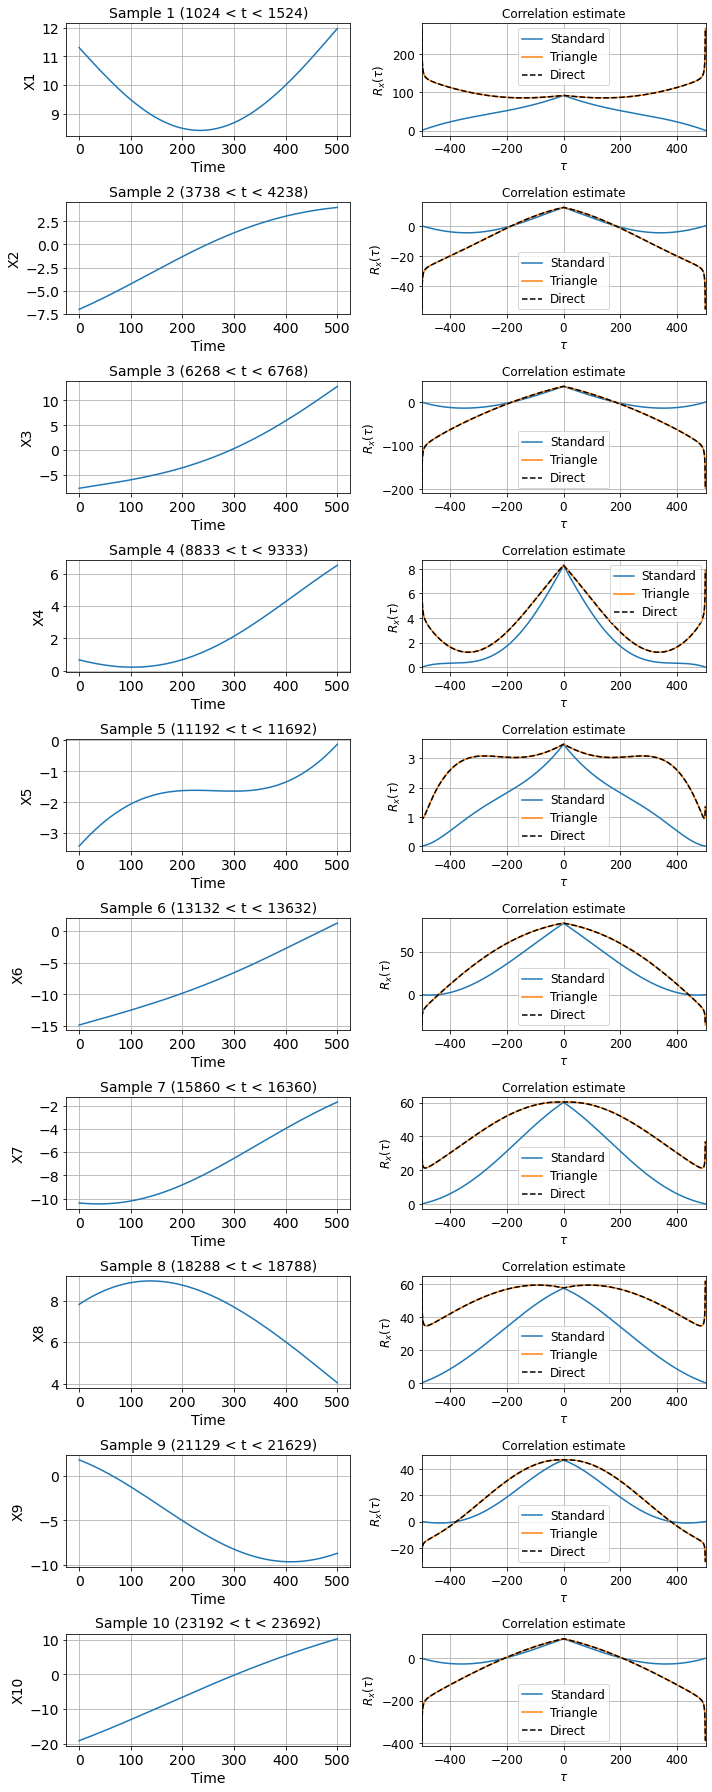

In [8]:
TFRAG = 500
NFRAG = 200

TSTARTS = np.round(np.linspace(TFRAG+1, T-TFRAG-1, NFRAG+1)).astype(int)[:-1]  # evenly spaced start times
TSTARTS += np.random.randint(0, 1000, NFRAG)  # add noise to start time

tcor_frag = np.arange(-TFRAG, TFRAG+1)

cors_dir = np.nan*np.zeros((NFRAG, len(tcor_frag)))
cors_std = np.nan*np.zeros((NFRAG, len(tcor_frag)))
cors_tri = np.nan*np.zeros((NFRAG, len(tcor_frag)))

nplot = 10
fig, axs_all = plt.subplots(nplot, 2, figsize=(10, 2.5*nplot), tight_layout=True)

x_frags = []

# get fragments
for cfrag, tstart in enumerate(TSTARTS):
    x_frag = x[tstart:tstart+TFRAG+1]
    x_frags.append(x_frag)
    
# get mean
mu_hat_x = np.mean(x_frags)

# estimate correlations
for cfrag, x_frag in enumerate(x_frags):
    cor_0_frag = xcor_direct(x_frag - mu_hat_x, x_frag - mu_hat_x, lag_bak=-TFRAG, lag_fwd=TFRAG+1)[0]
    cor_1_frag = xcor_conv_standard(x_frag - mu_hat_x, x_frag - mu_hat_x)[0]
    cor_2_frag = xcor_conv_tri(x_frag - mu_hat_x, x_frag - mu_hat_x)[0]
    
    cors_dir[cfrag] = cor_0_frag
    cors_std[cfrag] = cor_1_frag
    cors_tri[cfrag] = cor_2_frag
    
    tstart = TSTARTS[cfrag]
    tend = tstart + TFRAG
    
    if cfrag < 10:
        axs = axs_all[cfrag]
        
        axs[0].plot(x_frag)
        axs[0].grid()
        set_plot(axs[0], x_label='Time', y_label=f'X{cfrag+1}', title=f'Sample {cfrag+1} ({tstart} < t < {tend})', font_size=14)

        axs[1].plot(tcor_frag, cor_1_frag)
        axs[1].plot(tcor_frag, cor_2_frag)
        axs[1].plot(tcor_frag, cor_0_frag, c='k', ls='--')

        axs[1].legend(['Standard', 'Triangle', 'Direct'])

        axs[1].grid()
        set_plot(axs[1], x_lim=(-TFRAG, TFRAG), x_label=r'$\tau$', y_label=r'$R_x(\tau)$', title='Correlation estimate', font_size=12)

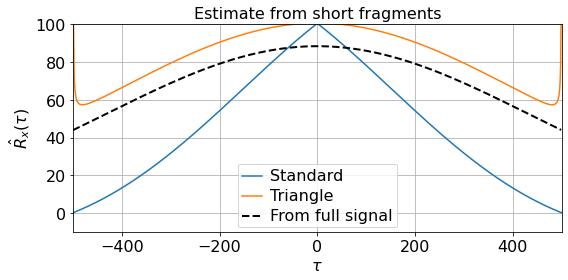

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), tight_layout=True)
ax.plot(tcor_frag, cors_std.mean(0))
ax.plot(tcor_frag, cors_tri.mean(0))
ax.plot(tcor_0, cor_0, c='k', ls='--', lw=2)
ax.legend(['Standard', 'Triangle', 'From full signal'])
set_plot(ax, x_lim=(-TFRAG, TFRAG), y_lim=(-10, 100), x_label=r'$\tau$', y_label=r'$\hat{R}_x(\tau)$', title='Estimate from short fragments', font_size=16)
ax.grid()

# Delta and exponential autocorrelation functions

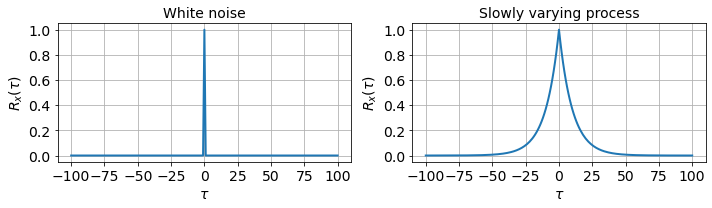

In [10]:
t = np.arange(-100, 101)
x = (t == 0).astype(float)

y = np.exp(-np.abs(t)/10)

fig, axs = plt.subplots(1, 2, figsize=(10, 3), tight_layout=True)
axs[0].plot(t, x, lw=2)
axs[0].set_title('White noise')

axs[1].plot(t, y, lw=2)
axs[1].set_title('Slowly varying process')


for ax in axs:
    ax.grid()
    set_plot(ax, x_label=r'$\tau$', y_label=r'$R_x(\tau)$', font_size=14)